## Augmentation `classes minoritaires`
## Reduction des `classes majoritaires`

`classes minoritaires` : classe de métier dont nombre d'individus est inférieur à la médiane.  
`classes majoritaires`: classe de métier dont nombre d'individus est supérieur à la médiane.

In [234]:
from sklearn import model_selection

from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import metrics

from IO_Kaggle import Import,Export
from txt_prep import deleteStopWords,cleanText

import pandas as pd
from pandas import DataFrame, Series
from nltk.stem import PorterStemmer 
from collections  import defaultdict

import dask
import dask.multiprocessing
from dask import delayed
import dask.dataframe as dd
import matplotlib.pyplot as plt
import string




# Nom des jobs
names = pd.read_csv('../data/categories_string.csv')['0'].to_dict()

data=Import(fileName='../data/train',fileExtension='json').set_index('Id')

train_label=pd.read_csv('../data/train_label.csv',index_col='Id')

data_test=Import(fileName='../data/test',fileExtension='json').set_index('Id')


#############################################################################
#####                 Statistiques descriptives                         #####
#############################################################################


description = pd.concat([train_label.Category, data.gender], axis = 1)
description.gender[description.gender=="F"] = 1
description.gender[description.gender=="M"] = 0

resume = pd.DataFrame({"label" : list(range(28)),
                      "femmes" : description.groupby("Category").sum().gender, 
                      "total" : description.groupby("Category").count().gender})

for i in range(len(resume)):
    resume.label[i] = names[resume.label[i]]

# Graph nb total d'individus par profession

resume.sort_values('total',inplace=True)
resume.plot(kind='barh',y='total',x='label',color='r')

/home/pierre/anaconda3/envs/ProjetSD/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/pierre/anaconda3/envs/ProjetSD/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: invalid literal for int() with base 10: 'pastor'

In [3]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
dirname='../data'

# Importation des `noms de métiers`
# Création du dico des `noms de métiers`
jobNames = pd.read_csv(os.path.join(dirname,'categories_string.csv'))['0'].to_dict()

# Importation du jeu de données d'entrainement
data=dd.read_json(os.path.join(dirname,'train.json'),lines=False).set_index('Id',n_partitions=10).categorize(columns=['gender'])

train_label=pd.read_csv(os.path.join(dirname, 'train_label.csv'),index_col='Id')

In [2]:
jobNames

{0: 'pastor',
 1: 'model',
 2: 'yoga_teacher',
 3: 'teacher',
 4: 'personal_trainer',
 5: 'painter',
 6: 'journalist',
 7: 'interior_designer',
 8: 'surgeon',
 9: 'accountant',
 10: 'dj',
 11: 'physician',
 12: 'comedian',
 13: 'software_engineer',
 14: 'nurse',
 15: 'poet',
 16: 'dentist',
 17: 'chiropractor',
 18: 'filmmaker',
 19: 'professor',
 20: 'photographer',
 21: 'rapper',
 22: 'psychologist',
 23: 'paralegal',
 24: 'architect',
 25: 'composer',
 26: 'attorney',
 27: 'dietitian'}

<AxesSubplot:ylabel='label'>

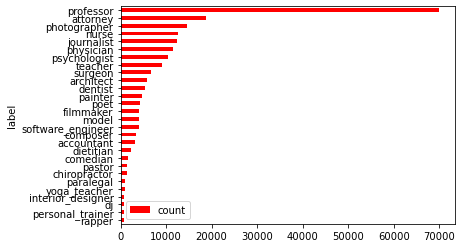

In [4]:
#description = train_label.assign(=data.gender)

#description.gender[description.gender=="F"] = 1
#description.gender[description.gender=="M"] = 0

resume=train_label.groupby(["Category"]).agg({"Category":["count"]})
resume.columns = resume.columns.droplevel(0)
resume['label']=resume.index.map(jobNames)

#print(resume.sort_values('count'))

# Graph nb total d'individus par profession
resume.sort_values('count',ascending=True,inplace=True)
resume.plot(kind='barh',y='count',x='label',color='r')

In [5]:
print(resume)

          count              label
Category                          
21          783             rapper
4           807   personal_trainer
10          831                 dj
7           858  interior_designer
2           944       yoga_teacher
23          967          paralegal
17         1406       chiropractor
0          1497             pastor
12         1639           comedian
27         2288          dietitian
9          3121         accountant
25         3395           composer
13         4060  software_engineer
1          4115              model
18         4124          filmmaker
15         4292               poet
5          4621            painter
16         5450            dentist
24         5841          architect
8          6616            surgeon
3          9145            teacher
22        10391       psychologist
11        11607          physician
6         12295         journalist
14        12622              nurse
20        14646       photographer
26        18820     

In [25]:
resume['count'].quantile([0.25, 0.5 , 0.75])

0.25    1474.25
0.50    4119.50
0.75    9456.50
Name: count, dtype: float64

In [ ]:
Listes_Maj=[]

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

def balanceClass(resume,data,label):
    """Pour chacun des métiers au dessus de la médiane : 
    1. Selectionner les classes où count > quantile(0.75).
    """
    def selectRows(data,label,classe,thsld):
        df=data.assign(metier=1*(label.Category==classe))
        Y=df.metier
        ## Initialise
        
        
        tfidf_vect=TfidfVectorizer(min_df=1000,ngram_range=(1, 2))
        clf=SGDClassifier(loss="modified_huber",penalty='l2',early_stopping=True,n_jobs=-1)
        pipeline = Pipeline([('vector',tfidf_vect),("clf",clf)])
        pipeline.fit(df.description,Y)
        pred=pipeline.predict_proba(df.description)
        pred_df=df.copy()
        pred_df['pred'] = pred[:,1]
        pred_df=pred_df.sort_values('pred',ascending=False)

        thsld_G=thsld//2
        
        pred_df_M=pred_df[pred_df.gender=='M'].iloc[:thsld_G]
        pred_df_F=pred_df[pred_df.gender=='F'].iloc[:thsld_G]
        FinalDF=pd.concat([pred_df_M, pred_df_F], ignore_index=True)

        return FinalDF

    
    index_list=0
    thresholdCount=resume['count'].quantile(0.5)
    classes=resume[resume['count']>thresholdCount].index.to_list()
    balanced_DF=[selectRows(data,label,classe,thresholdCount) for classe in classes]    
    
    
    print(balanced_DF)
    
    return classes,round(thresholdCount)

In [46]:
balanceClass(resume,data,train_label)

TypeError: Column assignment doesn't support type numpy.ndarray